# postprocessing_LSROM_SRPC
Notebook to postprocess DD FOM and DD LS-ROM solution data (e.g, computing errors, making plots)   
Author: Alejandro Diaz  
Date:  1/18/2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.sparse as sp
import scipy.linalg as la
from time import time
from utils.Burgers2D_probgen import Burgers2D
from utils.helpers import sp_diag
from utils.domain_decomposition import subdomain_indices, state_component, DD_FOM, DDFOM_data, subdomain_data
from utils.lsrom import compute_bases_from_svd, DD_LSROM, assemble_snapshot_matrix
from IPython.display import HTML, Image
from utils.solvers import newton_solve
import sys, os
import dill as pickle

In [2]:
plt.rc('font', size=20)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['text.usetex'] = True

In [3]:
# make directories for figures and data
data_dir = './data/'
fig_dir0 = './figures/'
for d in [data_dir, fig_dir0]:
    if not os.path.exists(d): os.mkdir(d)

## Set FOM parameters, initial condition

In [4]:
# parameters for physical domain and FD discretization
x_lim = [0, 1]
y_lim = [0, 1]
nx, ny    = 60, 60
viscosity = 1e-2

# number of subdomains in x and y directions
nsub_x, nsub_y = 4, 2
nsub = nsub_x*nsub_y

# time integration parameters
nt    = 1000
t_lim = [0, 2]
ht    = (t_lim[1]-t_lim[0])/nt

# parameter for initial condition
mu = 1.0

In [5]:
# parameterized initial conditions
def u0(XY, mu):
    val = np.zeros(len(XY))
    for i, xy in enumerate(XY):
        if np.all([xy[0] >= 0.0, xy[0] <= 0.5, xy[1] >= 0.0, xy[1] <= 0.5]):
            val[i] = mu*np.sin(2*np.pi*xy[0])*np.sin(2*np.pi*xy[1])
    return val 

def v0(XY, mu):
    val = np.zeros(len(XY))
    for i, xy in enumerate(XY):
        if np.all([xy[0] >= 0.0, xy[0] <= 0.5, xy[1] >= 0.0, xy[1] <= 0.5]):
            val[i] = mu*np.sin(2*np.pi*xy[0])*np.sin(2*np.pi*xy[1])
    return val 

## Initialize monolithic FOM and DD FOM

In [6]:
# initialize model
print('Initializing Burgers model...')
sys.stdout.flush()
fom = Burgers2D(nx, ny, x_lim, y_lim, viscosity)
print('Done!')

Initializing Burgers model...
Done!


In [7]:
# initialize DD FOM
ddfom = DD_FOM(fom, nsub_x, nsub_y)
ddfom.set_initial(lambda xy: u0(xy, mu), lambda xy: v0(xy, mu))

## Load FOM solution

In [8]:
ddfom_data = DDFOM_data(nx, ny, nt, viscosity, mu, nsub_x, nsub_y, data_dir)
ddfom_data.assemble_full_solution(ddfom)

In [9]:
ddfom_data.UU.shape

(1001, 60, 60)

## Load LS-ROM solution

In [10]:
# energy criteria for interior and interface bases
ec_res  = 1e-16
ec_intr = 1e-8
ec_intf = 1e-8
ec_port = 1e-8

# interior, interface, port basis size. set to -1 to use energy criterion
nbasis_res  = -1
nbasis_intr = 4
nbasis_intf = 8
nbasis_port = 2

# use full subdomain bases
full_sub = False

# constraint type
con_type      = 'srpc'        # 'srpc' (strong ROM-port constraints) or 'wfpc' (weak FOM-port constraints)
n_constraints = 1             # number of constraints for WFPC formulation

# hyper reduction
hr           = True
sample_ratio = 2.0
n_samples    = -1

In [11]:
class DDLSROM_data(DDFOM_data):
    def __init__(self, nx, ny, nt, viscosity, mu, nsub_x, nsub_y,
                ec_intr, ec_intf, ec_port, nbasis_intr, nbasis_intf, nbasis_port, full_sub, 
                con_type, n_constraints, hr, sample_ratio, n_samples, data_dir):
        
        self.nx   = nx
        self.ny   = ny
        self.nt   = nt
        self.viscosity = viscosity
        self.mu   = mu
        self.nsub_x = nsub_x
        self.nsub_y = nsub_y
        self.nsub = nsub_x*nsub_y
        self.nxy  = nx*ny
        
        # assemble file locations
        data_dir2 = data_dir + f'nx_{nx}_ny_{ny}_nt_{nt}_visc_{viscosity}/DD_{nsub_x}x_by_{nsub_y}y/' 
        con_dir  = 'srpc/' if con_type == 'srpc' else f'wfpc_ncon_{n_constraints}/'
        intr_str = f'ecintr_{ec_intr:1.0e}_' if nbasis_intr < 0 else f'intr_{nbasis_intr}_'
        if con_type == 'srpc':
            intf_str = f'ecport_{ec_port:1.0e}_' if nbasis_port < 0 else f'port_{nbasis_port}_'
        else:
            intf_str = f'ecintf_{ec_intf:1.0e}_' if nbasis_intf < 0 else f'intf_{nbasis_intf}_'
        if hr:
            hr_str = f'hr_{n_samples}_' if n_samples > 0 else f'hr_{sample_ratio}x_'
        else:
            hr_str = ''
    
        self.subdomain = []
        for i in range(self.nsub):
            sub_dir  = data_dir2 + f'sub_{i+1}of{self.nsub}/'
            intr_dir = sub_dir + 'interior/' + con_dir
            intf_dir = sub_dir + 'interface/' + con_dir

            intr_filename = intr_dir + f'lsrom_{intr_str}{hr_str}mu_{mu}_state.p'
            intf_filename = intf_dir + f'lsrom_{intf_str}{hr_str}mu_{mu}_state.p'

            intr_dict = pickle.load(open(intr_filename, 'rb'))
            intf_dict = pickle.load(open(intf_filename, 'rb'))
    
            self.subdomain.append(subdomain_data(intr_dict, intf_dict))
        
        self.runtime = self.subdomain[0].interior.runtime
        self.nt      = self.subdomain[0].interior.u.shape[0]-1
        print(f'DD LS-ROM stopped after {self.nt} time steps.')
    
    def compute_error(self, ddfom):
        # Compute error
        abserr = np.zeros(self.nt+1)
        for i, s in enumerate(self.subdomain):
            abserr += np.sum(np.square(ddfom.subdomain[i].interior.u[:self.nt+1]-s.interior.u), 1) + \
                      np.sum(np.square(ddfom.subdomain[i].interior.v[:self.nt+1]-s.interior.v), 1) + \
                      np.sum(np.square(ddfom.subdomain[i].interface.u[:self.nt+1]-s.interface.u), 1) + \
                      np.sum(np.square(ddfom.subdomain[i].interface.v[:self.nt+1]-s.interface.v), 1)

        abserr = np.sqrt(abserr/self.nsub/self.nxy)
        maxk   = abserr.argmax()
        abserr = abserr.max()
        print(f'Absolute error = {abserr:1.4e}')
        print(f'max error tk   = {maxk}')
        print(f'FOM runtime    = {ddfom.runtime:1.3e} seconds')
        print(f'ROM runtime    = {self.runtime:1.3e} seconds')
        print(f'Speedup        = {ddfom.runtime/self.runtime}')
        return maxk, abserr

In [12]:
ddlsrom_data = DDLSROM_data(nx, ny, nt, viscosity, mu, nsub_x, nsub_y,
                ec_intr, ec_intf, ec_port, nbasis_intr, nbasis_intf, nbasis_port, full_sub, 
                con_type, n_constraints, hr, sample_ratio, n_samples, data_dir)
ddlsrom_data.assemble_full_solution(ddfom)
maxk, abserr = ddlsrom_data.compute_error(ddfom_data)

DD LS-ROM stopped after 1000 time steps.
Absolute error = 7.7237e-03
max error tk   = 198
FOM runtime    = 5.214e+02 seconds
ROM runtime    = 1.745e+01 seconds
Speedup        = 29.88779395289713


In [18]:
fomdof = 0
romdof = 0
for s in ddlsrom_data.subdomain: 
    fomdof += s.interior.basis.shape[0]+s.interface.basis.shape[0]
    romdof += s.interior.basis.shape[1]+s.interface.basis.shape[1]
fomdof, romdof

(8160, 144)

## View solution

In [13]:
# frame updater for animation
umin = np.min([s.interior.u.min() for s in ddfom_data.subdomain]+
              [s.interface.u.min() for s in ddfom_data.subdomain])
umax = np.max([s.interior.u.max() for s in ddfom_data.subdomain]+
              [s.interface.u.max() for s in ddfom_data.subdomain])
vmin = np.min([s.interior.v.min() for s in ddfom_data.subdomain]+
              [s.interface.v.min() for s in ddfom_data.subdomain])
vmax = np.max([s.interior.v.max() for s in ddfom_data.subdomain]+
              [s.interface.v.max() for s in ddfom_data.subdomain])

X, Y = np.meshgrid(fom.xx, fom.yy)
def update_frame(i, Z, zmin, zmax, cb_label):
    plt.clf()
    plt.pcolormesh(X, Y, Z[i], cmap='viridis', shading='auto', vmin=zmin, vmax=zmax) 
#     plt.xlabel('$x$')
#     plt.ylabel('$y$')
#     plt.title('$t_{'+f'{i:4d}'+'}' + f'={ht*i+t_lim[0]:1.4f}$')
    cb = plt.colorbar(orientation='vertical')#, label=cb_label)
    return plt

In [14]:
con_dir   = 'srpc/' if con_type == 'srpc' else f'wfpc_ncon_{n_constraints}/'
fom_figs =  f'./figures/nx_{nx}_ny_{ny}_nt_{nt}_visc_{viscosity}/mu_{mu}/ddfom_{nsub_x}x_by_{nsub_y}y/'
rom_figs =  f'./figures/nx_{nx}_ny_{ny}_nt_{nt}_visc_{viscosity}/mu_{mu}/ddlsrom_{nsub_x}x_by_{nsub_y}y/{con_dir}snapshots/'
if not os.path.exists(rom_figs):os.mkdir(rom_figs)
    
intr_str = f'ecintr_{ec_intr:1.0e}_' if nbasis_intr < 0 else f'intr_{nbasis_intr}_'
if con_type == 'srpc':
    intf_str = f'ecport_{ec_port:1.0e}_' if nbasis_port < 0 else f'port_{nbasis_port}_'
else:
    intf_str = f'ecintf_{ec_intf:1.0e}_' if nbasis_intf < 0 else f'intf_{nbasis_intf}_'
    
hr_str    = f'hr_{sample_ratio}x_' if hr else ''

Max error = 0.16892575216718103
argmax k  = 198


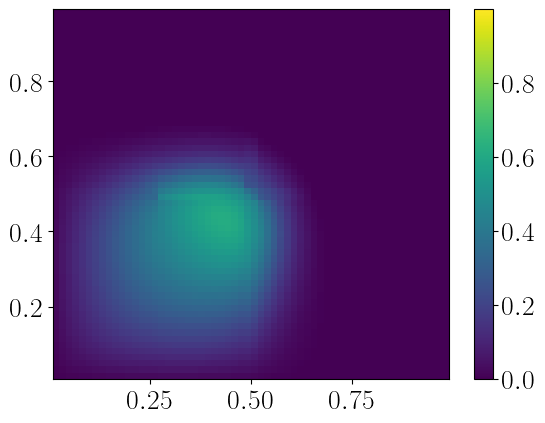

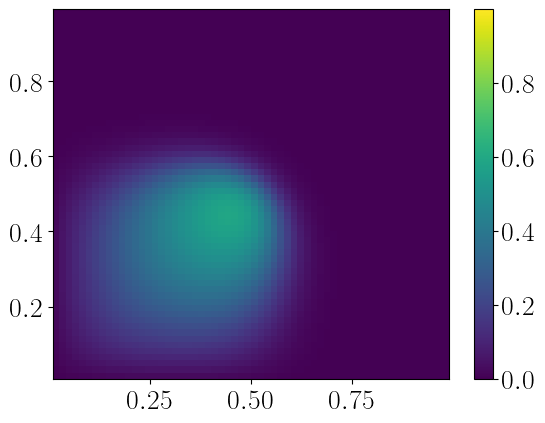

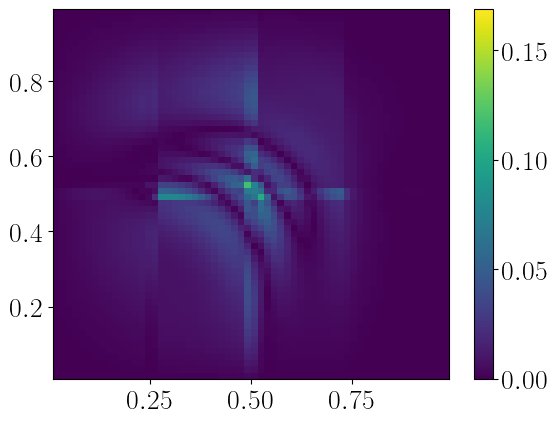

In [15]:
tk     = maxk

prefix = rom_figs + f't{tk}_{intr_str}{intf_str}{hr_str}'
error  = np.abs(ddfom_data.UU - ddlsrom_data.UU)

max_error = error.max() #0.9758983174638546

print(f'Max error = {error.max()}')
print(f'argmax k  = {maxk}')

update_frame(tk, ddlsrom_data.UU, umin, umax, '$u(t, x, y)$')
plt.savefig(prefix + "u_state.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

update_frame(tk, ddfom_data.UU, umin, umax, '$u(t, x, y)$')
plt.savefig(fom_figs+f't{tk}_u_state.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

update_frame(tk, error, 0.0, max_error, 'error')
plt.savefig(prefix + f"error_max{max_error:1.3e}.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

## Sandbox

In [16]:
me_srpc = 0.016550346384635276
me_wfpc = 0.9913668126427289

In [17]:
tk_wfpc = maxk

In [18]:
data_dir2 = data_dir + f'nx_{nx}_ny_{ny}_nt_{nt}_visc_{viscosity}/DD_{nsub_x}x_by_{nsub_y}y/' 
hrfile = data_dir2 + f'{intr_str}{intf_str}{hr_str}ithist.p'
file = data_dir2 + f'{intr_str}{intf_str}ithist.p'

it_hist = pickle.load(open(file, 'rb'))
it_hist_hr = pickle.load(open(hrfile, 'rb'))

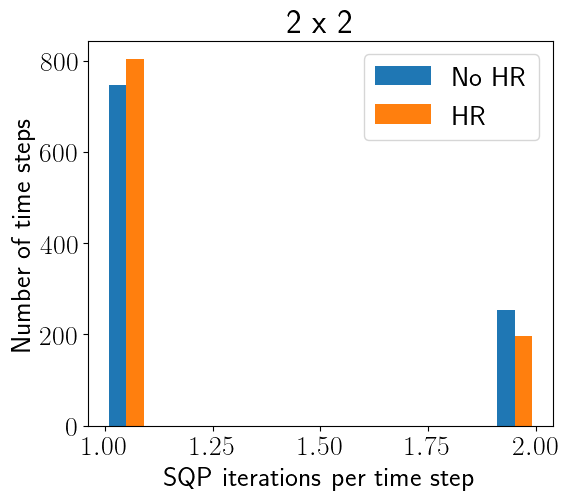

In [19]:
plt.figure(figsize=(6, 5))
plt.hist([it_hist, it_hist_hr], label=['No HR', 'HR'])
plt.xlabel('SQP iterations per time step')
plt.ylabel('Number of time steps')
plt.title(f'{nsub_x} x {nsub_y}')
plt.legend(loc='best')
plt.savefig(rom_figs + f'{intr_str}{intf_str}iter_histogram.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [22]:
np.mean(it_hist)

1.254

In [23]:
np.mean(it_hist_hr)

1.196